In [1]:
import requests
import json

In [2]:
dati_comuni=requests.get('https://raw.githubusercontent.com/MatteoHenryChinaski/Comuni-Italiani-2018-Sql-Json-excel/master/italy_cities.json').json()
comuniGeojson=requests.get('https://raw.githubusercontent.com/openpolis/geojson-italy/master/geojson/limits_IT_municipalities.geojson').json()

In [3]:
dati_province=requests.get('https://raw.githubusercontent.com/MatteoHenryChinaski/Comuni-Italiani-2018-Sql-Json-excel/master/italy_provincies.json').json()
provinceGeojson=requests.get('https://raw.githubusercontent.com/openpolis/geojson-italy/master/geojson/limits_IT_provinces.geojson').json()

In [4]:
covidProvincie=requests.get('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-province-latest.json').json()

In [5]:
dati_comuni[0],dati_province[0]

({'istat': '1001',
  'comune': 'Agliè',
  'regione': 'Piemonte',
  'provincia': 'TO',
  'prefisso': '124',
  'cod_fisco': 'A074',
  'superficie': '13.28',
  'num_residenti': '2669'},
 {'sigla': 'AG',
  'provincia': 'Agrigento',
  'superficie': '3044.85',
  'residenti': '446081',
  'num_comuni': '43',
  'id_regione': '15'})

In [6]:
for i,comune in enumerate(dati_comuni[:-2]):
    prov_code=comune['provincia']
    prov_pop=0
    for provincia in dati_province[:-2]:
        if provincia['sigla']==prov_code:
            prov_pop=float(provincia['residenti'])
            dati_comuni[i]['density']=float(comune['num_residenti'])/prov_pop




0.001183739000851547

In [7]:
for i,comune in enumerate(dati_comuni[:-2]):
    prov_code=comune['provincia']
    prov_pop=0
    for provincia in covidProvincie:
        if provincia['sigla_provincia']==prov_code:
            prov_covid=float(provincia['totale_casi'])
            dati_comuni[i]['covid']=dati_comuni[i]['density']*prov_covid

In [8]:
dati_comuni[0]

{'istat': '1001',
 'comune': 'Agliè',
 'regione': 'Piemonte',
 'provincia': 'TO',
 'prefisso': '124',
 'cod_fisco': 'A074',
 'superficie': '13.28',
 'num_residenti': '2669',
 'density': 0.001183739000851547,
 'covid': 61.481036226227644}

In [9]:
covidProvincie=requests.get('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-province-latest.json').json()

In [10]:
comuniGeojson['features'][0]["properties"]

{'name': 'Agliè',
 'op_id': '130',
 'minint_elettorale': '1010810010',
 'prov_name': 'Torino',
 'prov_istat_code': '001',
 'prov_istat_code_num': 1,
 'prov_acr': 'TO',
 'reg_name': 'Piemonte',
 'reg_istat_code': '01',
 'reg_istat_code_num': 1,
 'opdm_id': '1',
 'com_catasto_code': 'A074',
 'com_istat_code': '001001',
 'com_istat_code_num': 1001}

In [11]:
for i,comGeo in enumerate(comuniGeojson['features'][:3]):
    for comune in dati_comuni[:-2]:
        if str(comGeo['properties']['com_catasto_code'])==comune['cod_fisco']:
            comuniGeojson['features'][i]['properties']['covid']=comune['covid']

In [18]:
comuniGeojson["features"][0]

{'type': 'Feature',
 'properties': {'name': 'Agliè',
  'op_id': '130',
  'minint_elettorale': '1010810010',
  'prov_name': 'Torino',
  'prov_istat_code': '001',
  'prov_istat_code_num': 1,
  'prov_acr': 'TO',
  'reg_name': 'Piemonte',
  'reg_istat_code': '01',
  'reg_istat_code_num': 1,
  'opdm_id': '1',
  'com_catasto_code': 'A074',
  'com_istat_code': '001001',
  'com_istat_code_num': 1001,
  'covid': 61.481036226227644},
 'geometry': {'type': 'MultiPolygon',
  'coordinates': [[[[7.782661515272468, 45.387173495222584],
     [7.7910600054132555, 45.386299574441175],
     [7.78970213841617, 45.38468296634535],
     [7.790383377827609, 45.38328598327816],
     [7.798943942272905, 45.376535355178675],
     [7.799499099039531, 45.376253151602604],
     [7.800426822639241, 45.3758668492953],
     [7.80282043916414, 45.37493332886601],
     [7.803001902144609, 45.36813026378089],
     [7.803003262357942, 45.368008756886354],
     [7.803009886582579, 45.3673922236556],
     [7.80266032939473

In [13]:
#json.dump(comuniGeojson,open("comuniCovidStat.json",'w'))

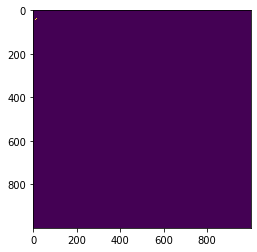

In [29]:
import numpy as np
import rasterio
from rasterio.features import rasterize
from rasterio.transform import IDENTITY
from matplotlib import pyplot
import affine
import json
import random

rows = cols = 1000
comuniGeojson=json.load(open("comuniCovidStat.json"))

with rasterio.Env():
    result = rasterize([(x["geometry"],10000) for x in comuniGeojson['features']], out_shape=(rows, cols))
    with rasterio.open(
            "test.tif",
            'w+', # Open the file in read/write mode
            driver='GTiff',
            width=cols,
            height=rows,
            count=1,
            dtype=rasterio.uint8,
            nodata=0,
            transform = affine.Affine.translation(7-.0, -45.0)*affine.Affine.scale(1/1000000000000),
            crs={'init': "EPSG:4326"}) as out:
        out.write(result.astype(rasterio.uint8), indexes=1)
        # Plot the image.
        pyplot.imshow(out.read(1))
        pyplot.show()